In [1]:
import pandas as pd
import sqlite3
conn = sqlite3.connect('tmdb.db')

In [2]:
c = conn.cursor()

In [62]:
c.execute("""SELECT * FROM genres""").fetchall()

[(1, 28, 'Action'),
 (2, 12, 'Adventure'),
 (3, 16, 'Animation'),
 (4, 35, 'Comedy'),
 (5, 80, 'Crime'),
 (6, 99, 'Documentary'),
 (7, 18, 'Drama'),
 (8, 10751, 'Family'),
 (9, 14, 'Fantasy'),
 (10, 36, 'History'),
 (11, 27, 'Horror'),
 (12, 10402, 'Music'),
 (13, 9648, 'Mystery'),
 (14, 10749, 'Romance'),
 (15, 878, 'Science Fiction'),
 (16, 10770, 'TV Movie'),
 (17, 53, 'Thriller'),
 (18, 10752, 'War'),
 (19, 37, 'Western')]

In [64]:
genres = pd.read_sql('SELECT * FROM genres', conn)

In [5]:
genre_info = pd.read_sql('SELECT * FROM genre_info', conn)

In [12]:
genre_info.drop(['index'], axis = 1, inplace = True)

In [9]:
top_rated_df = pd.read_sql('SELECT * FROM top_rated', conn)

In [13]:
top_rated_df.drop(['index'], axis = 1, inplace = True)

In [14]:
genre_merged = pd.merge(top_rated_df, genre_info, on = 'id')

In [73]:
genre_merged = pd.merge(genres, genre_merged, left_on = 'id', right_on = 'genre_id')

In [53]:
genre_merged = genre_merged.groupby('genre_id').filter(lambda x : len(x)>= 10)

In [79]:
genre_merged.drop(['index', 'id_x'], axis = 1, inplace = True)

In [16]:
import pandas as pd
import statsmodels.api as sm
from statsmodels.formula.api import ols
import scipy.stats as stats
from statsmodels.stats.multicomp import pairwise_tukeyhsd

In [75]:
genre_merged.genre.value_counts()

Comedy             147
Drama              137
Action              67
Thriller            52
Horror              32
Science Fiction     30
Crime               21
Adventure           21
Romance             20
Animation           17
Mystery             14
Documentary         14
Name: genre, dtype: int64

In [55]:
stats.shapiro(genre_merged['vote_average'])

(0.9915781617164612, 0.0024627158418297768)

In [76]:
formula = 'vote_average ~ C(genre)'
lm = ols(formula, genre_merged).fit()
table = sm.stats.anova_lm(lm, typ=2)
print(table)

              sum_sq     df         F        PR(>F)
C(genre)   78.684307   11.0  9.498925  8.539053e-16
Residual  421.705256  560.0       NaN           NaN


In [84]:
m_comp = pairwise_tukeyhsd(endog=genre_merged['vote_average'], groups=genre_merged['genre'], alpha=0.05)
type(m_comp)


statsmodels.sandbox.stats.multicomp.TukeyHSDResults

In [85]:
tukey = pd.DataFrame(data=m_comp._results_table.data[1:], columns=m_comp._results_table.data[0])


In [102]:
tukey[tukey['reject'] == 1]

,group1,group2,meandiff,lower,upper,reject
1,Action,Animation,0.8738,0.1004,1.6473,True
4,Action,Documentary,1.4138,0.5768,2.2507,True
5,Action,Drama,0.6494,0.2248,1.0740,True
14,Adventure,Documentary,1.1405,0.1578,2.1232,True
25,Animation,Horror,-1.2779,-2.1327,-0.4232,True
26,Animation,Mystery,-1.1458,-2.1737,-0.1179,True
28,Animation,Science Fiction,-1.1296,-1.9942,-0.2650,True
29,Animation,Thriller,-0.8010,-1.5967,-0.0053,True
31,Comedy,Documentary,1.1942,0.3976,1.9908,True
32,Comedy,Drama,0.4298,0.0916,0.7680,True


In [100]:
tukey.reject.value_counts()

False    45
True     21
Name: reject, dtype: int64

In [83]:
import seaborn as sns
from matplotlib import pyplot as plt

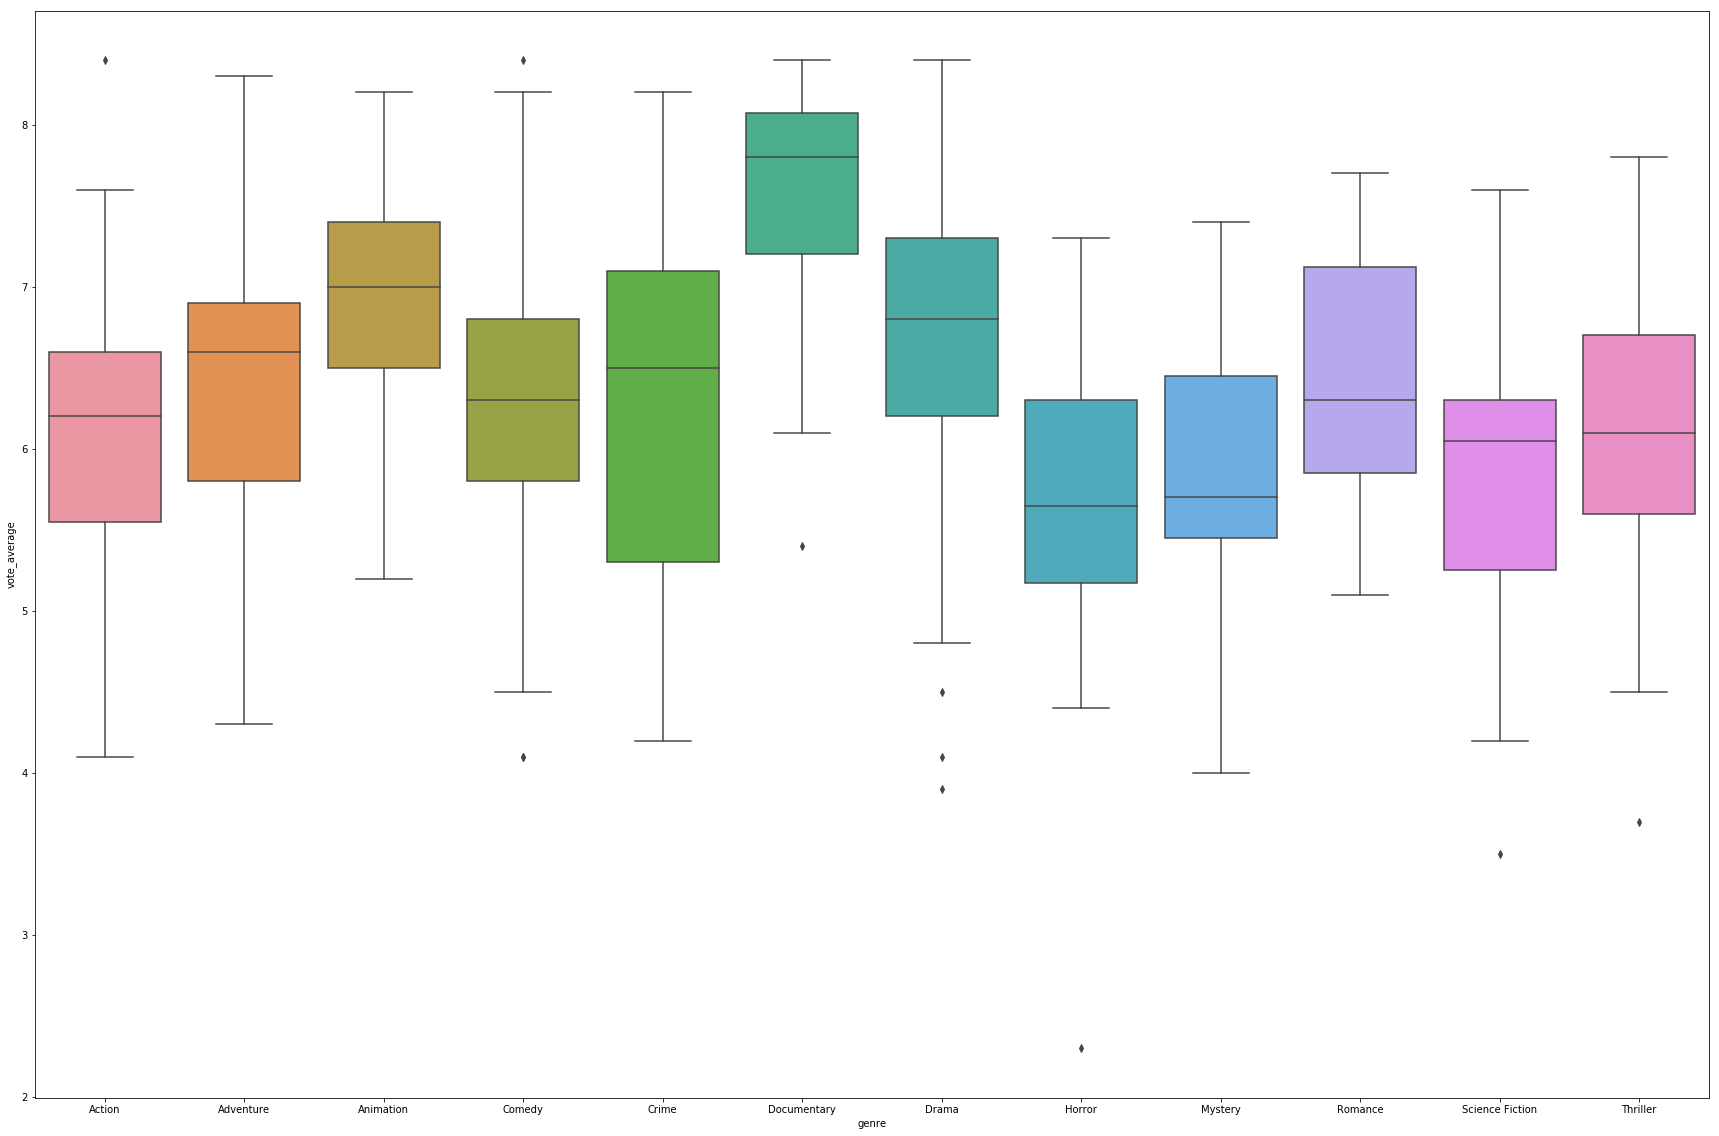

In [82]:
plt.figure(figsize=(30, 20))
sns.boxplot(x = genre_merged['genre'], y = genre_merged['vote_average'])
# make prettier
